In [36]:
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
# ImageDataGenerator for generating batches of augmented image data in real-time during training
from tensorflow.keras.models import Sequential
# Layers for the Sequential model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [37]:
class_names = {
    0: "crack",
    1: "scratch",
    2: "tire flat",
    3: "dent",
    4: "glass shatter",
    5: "lamp broken"
}

class_names_list = [
    "crack",
    "scratch",
    "tire flat",
    "dent",
    "glass shatter",
    "lamp broken"
]

In [ ]:
# Config
df = pd.read_csv("train/train.csv")
image_size = (120, 120)

# Load and preprocess training images
def process_image(path):
    img = load_img(path, target_size=image_size)
    return img_to_array(img) / 255.0

# Apply to training images
x = np.array([process_image(f"train\\images\\" + fname) for fname in df["filename"]])
y = np.array(df["label"])  # already numerical
y = y - 1 

# Split training set into training and validation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=23)


# Print the shape of each array.
print("x_train shape is:", x_train.shape)
print("x_test shape is:", x_test.shape)
print("y_train shape is:", y_train.shape)
print("y_test shape is:", y_test.shape)


In [38]:
# Config
df = pd.read_csv("train/train.csv")
image_size = (100, 100)
batch_size = 1000  # adjust based on available memory

x_chunks = []
y_chunks = []

# Process images in batches
for start in range(0, len(df), batch_size):
    end = start + batch_size
    batch_filenames = df["filename"].iloc[start:end]
    batch_labels = df["label"].iloc[start:end]

    x_batch = np.array([
        img_to_array(load_img(f"train/images/{fname}", target_size=image_size)) / 255.0 # Normalized
        for fname in batch_filenames
    ])
    y_batch = np.array(batch_labels)

    x_chunks.append(x_batch)
    y_chunks.append(y_batch)

# Combine all batches
x = np.concatenate(x_chunks, axis=0)
y = np.concatenate(y_chunks, axis=0)
y = y - 1 

# Split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=23)

# Print shapes
print("x_train shape is:", x_train.shape)
print("x_test shape is:", x_test.shape)
print("y_train shape is:", y_train.shape)
print("y_test shape is:", y_test.shape)

x_train shape is: (5760, 100, 100, 3)
x_test shape is: (1440, 100, 100, 3)
y_train shape is: (5760,)
y_test shape is: (1440,)


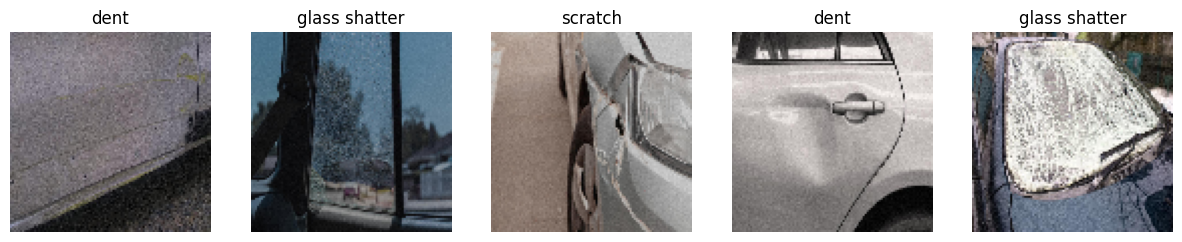

In [4]:
# Plot the first 5 images from the training set
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(x_train[i])
    axs[i].set_title(class_names[y_train[i]])
    axs[i].axis('off')
plt.show()

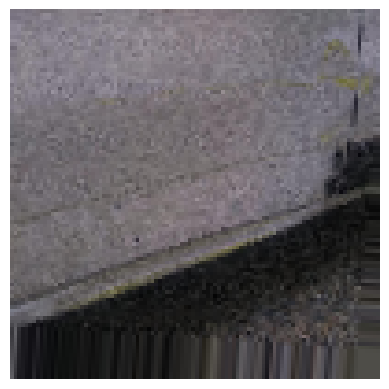

In [5]:
# Preprocessing; image transformations for data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Allow for some random transformation for the model
# Helps in squeezing more out of data then just using stock
train_datagen = ImageDataGenerator(
                    rotation_range=20, # Randomly rotate images up to 20 degrees
                    width_shift_range=0.1, # Randomly shift images horizontally up to 10% of the width
                    height_shift_range=0.1, # Randomly shift images vertically up to 10% of the height
                    horizontal_flip=True, # Randomly flip images horizontally
                    vertical_flip=False, # Don't randomly flip images vertically
                    shear_range=0.10, # crops part of the image
                    zoom_range=0.10) # #zooms the image by 10%


# Fit to training dataset
train_datagen.fit(x_train)

# Apply the random_transform function to the first image to check
new_image = train_datagen.random_transform(x_train[0])
plt.imshow(new_image)
plt.gca().axis("off")
plt.show()

In [6]:
# Constructor stage for CNN

# 2-dimensional Convolution layer (Conv2D) with 200 filters, a kernel size of 3x3, and the ReLU activation function
# Ensure that the input shape matches the shape of the input images (100, 100, 3) (height, width, # of channels)

model = Sequential()

# 1st layer and sets the input shape
model.add(Input(shape=(100, 100, 3)))

# Convolution layer for 100 filters, 
# kernel size (width x height so  3 channels x 3), 
# and a function for non-linear activation (relu)
# Padding keeps output the same size as input
model.add(Conv2D(filters=100, kernel_size=(3,3), activation='relu', padding='same'))

# Pooling layer to "simplify" and "contrast" data passing through the network
model.add(MaxPooling2D(pool_size=(2,2)))

# Add second convulution layer, increasing the filter count as is the norm
model.add(Conv2D(filters=200, kernel_size=(3,3), activation='relu', padding='same'))

# Add a second max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

# Add a third convolutional layer
model.add(Conv2D(filters=400, kernel_size=(3,3), activation='relu', padding='same'))

# Add a third max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten our multidimensional outputs to a 1D array
model.add(Flatten())

# Add a Dense layer with fully connected neurons
model.add(Dense(200,  activation='relu'))

# Dropout rate of 50%
model.add(Dropout(0.5))

# 6 units for the 6 output classes
# Softmax activation function to output values as probabilities for the 6 classes
model.add(Dense(6,  activation='softmax'))


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 100)       │           2,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 200)         │         180,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 200)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 400)         │         720,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 400)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │      11,520,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,206 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,424,806 (47.40 MB)

 Trainable params: 12,424,806 (47.40 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile

#categorical_crossentropy - loss function during model training
#accuracy - Evaluation measure (metric)
#SGD - Stochastic Gradient Descent (optimizer)

# learning_rate=0.01 specifies the step size of the weight updates training (0.01 small weight change, 0.1 big weight change)
# Too small might lead to slow learning, but too fast a jump might lead to skipping over good solutions

# momentum=0.9 accelerates the direction of the gradient and dampen oscillations
# Uses how the data moved through the network previously to favour it more (to the desired extent); inertia in the network

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train

# to_categorical() converts integer class labels into one-hot encoded vectors
# also used to convert predicted scores back into class labels for evaluation in classification problems

# batch_size is the size of the group of data being used to train at a time

# epochs; number of times the data is passed through the model

history=model.fit(train_datagen.flow(x_train, keras.utils.to_categorical(y_train), batch_size=32),
                  epochs=20, validation_data=(x_test, keras.utils.to_categorical(y_test)))

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.3095 - loss: 1.5753 - val_accuracy: 0.4243 - val_loss: 1.4066
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.3553 - loss: 1.4799 - val_accuracy: 0.4111 - val_loss: 1.3519
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.3988 - loss: 1.3827 - val_accuracy: 0.4243 - val_loss: 1.3741
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.4383 - loss: 1.3369 - val_accuracy: 0.4333 - val_loss: 1.2775
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.4571 - loss: 1.2640 - val_accuracy: 0.4806 - val_loss: 1.1912
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.4772 - loss: 1.2194 - val_accuracy: 0.5056 - val_loss: 1.1164
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 199s 998ms/step - accuracy: 0.4827 - loss: 1.1746 - val_accuracy: 0.5208 - val_loss: 1.0903
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.5101 - loss: 1.1484 - val_a

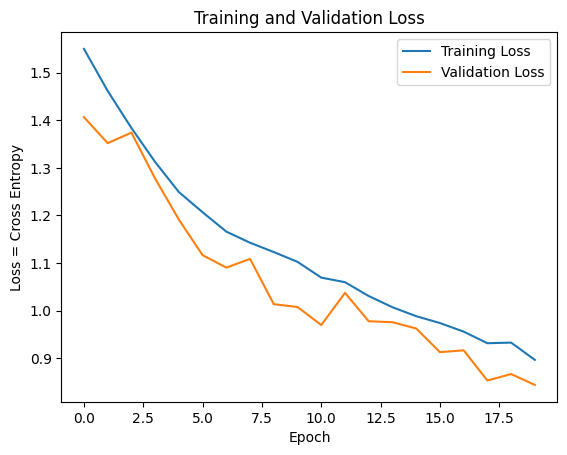

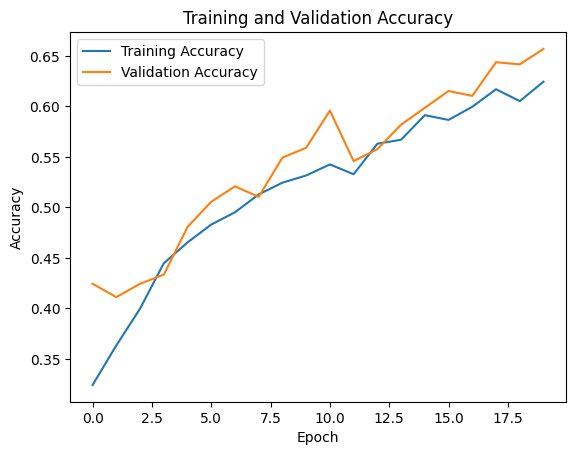

In [11]:
## Checking for overfitting

# Plot training loss against validation loss
#Plots the training loss as a line with label "Training Loss".
plt.plot(history.history['loss'], label='Training Loss')
#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Loss".
plt.ylabel('Loss = Cross Entropy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()


# Plot training and validation accuracy
#Plots the training accuracy as a line with label "Training Accuracy".
plt.plot(history.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Accuracy".
plt.ylabel('Accuracy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

In [16]:
# Predict the classes of the test set
# Recall that the outputs from the model give the probability of each class label
# The argmax returns the class with the largest predicted probability

# Classification Report
y_pred = np.argmax(model.predict(x_test), axis=-1)
print(classification_report(y_test, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 270ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.70      0.58      0.63       515
           2       0.88      0.86      0.87       101
           3       0.53      0.63      0.58       405
           4       0.78      0.90      0.84       226
           5       0.59      0.62      0.61       162

    accuracy                           0.66      1440
   macro avg       0.58      0.60      0.59      1440
weighted avg       0.65      0.66      0.65      1440



C:\Users\bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

<Figure size 2000x3000 with 0 Axes>

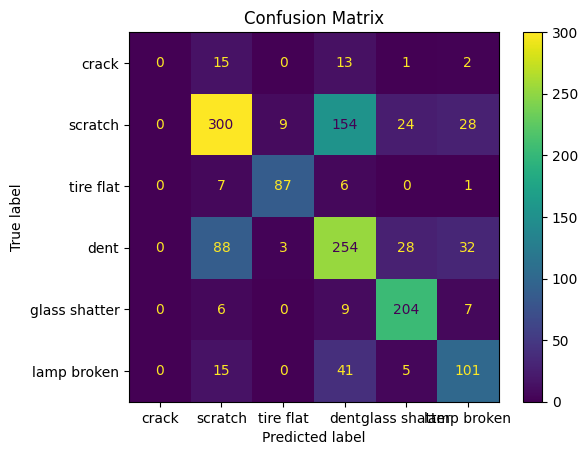

In [23]:
# Confusion Matrix

plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred, display_labels=class_names_list)
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Hyperparameter tuning with increased batch size

# 2-dimensional Convolution layer (Conv2D) with 200 filters, a kernel size of 3x3, and the ReLU activation function
# Ensure that the input shape matches the shape of the input images (100, 100, 3) (height, width, # of channels)

model = Sequential()

# 1st layer and sets the input shape
model.add(Input(shape=(100, 100, 3)))

# Convolution layer for 200 filters, 
# kernel size (width x height), 
# and a function for non-linear activation (relu)
# Padding keeps output the same size as input
model.add(Conv2D(filters=100, kernel_size=(3,3), activation='relu', padding='same'))

# Pooling layer to "simplify" and "contrast" data passing through the network
model.add(MaxPooling2D(pool_size=(2,2)))

# Add second convulution layer, increasing the filter count as is the norm
model.add(Conv2D(filters=200, kernel_size=(3,3), activation='relu', padding='same'))

# Add a second max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

# Add a third convolutional layer
model.add(Conv2D(filters=400, kernel_size=(3,3), activation='relu', padding='same'))

# Add a third max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten our multidimensional outputs to a 1D array
model.add(Flatten())

# Add a Dense layer with fully connected neurons
model.add(Dense(200,  activation='relu'))

# Dropout rate of 50%
model.add(Dropout(0.5))

# 6 units for the 6 output classes
# Softmax activation function to output values as probabilities for the 6 classes
model.add(Dense(6,  activation='softmax'))


model.summary()

# Compile
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Train (with increased batch size)
history=model.fit(train_datagen.flow(x_train, keras.utils.to_categorical(y_train), batch_size=128),
                  epochs=20, validation_data=(x_test, keras.utils.to_categorical(y_test)))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 100, 100, 100)       │           2,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 50, 50, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 200)         │         180,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 25, 25, 200)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 400)         │         720,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 400)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 200)                 │      11,520,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,206 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,424,806 (47.40 MB)

 Trainable params: 12,424,806 (47.40 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.2989 - loss: 1.6445 - val_accuracy: 0.3625 - val_loss: 1.5276
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.3381 - loss: 1.5463 - val_accuracy: 0.3938 - val_loss: 1.4461
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.3502 - loss: 1.5024 - val_accuracy: 0.4104 - val_loss: 1.3833
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.3857 - loss: 1.4299 - val_accuracy: 0.4375 - val_loss: 1.3108
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.4295 - loss: 1.3446 - val_accuracy: 0.4111 - val_loss: 1.3153
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.4357 - loss: 1.3057 - val_accuracy: 0.4569 - val_loss: 1.2439
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.4729 - loss: 1.2730 - val_accuracy: 0.4639 - val_loss: 1.2159
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - accuracy: 0.4825 - loss: 1.2261 - val_accuracy: 0.5153 - v

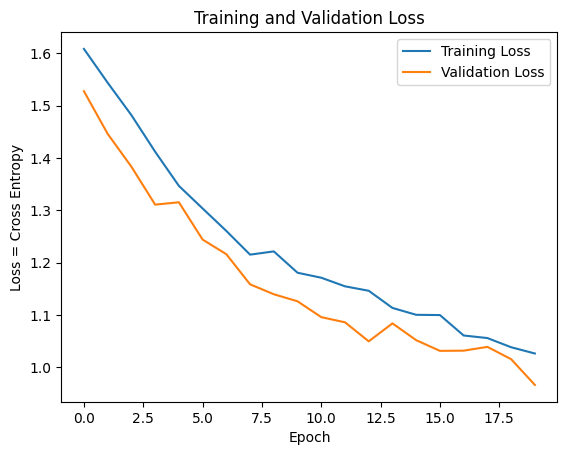

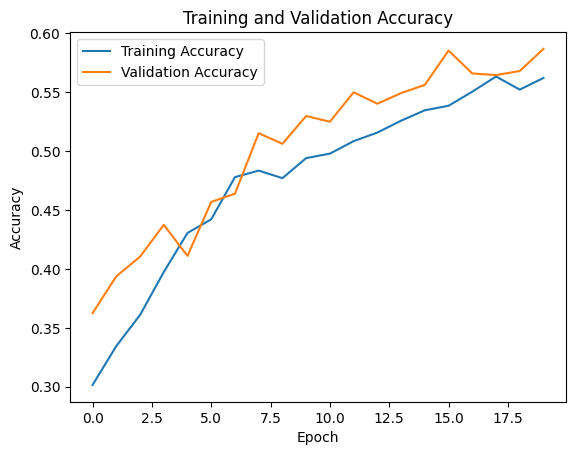

45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 267ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.53      0.81      0.64       515
           2       0.73      0.80      0.76       101
           3       0.62      0.21      0.31       405
           4       0.74      0.82      0.78       226
           5       0.51      0.46      0.48       162

    accuracy                           0.59      1440
   macro avg       0.52      0.52      0.50      1440
weighted avg       0.59      0.59      0.55      1440



C:\Users\bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

<Figure size 2000x3000 with 0 Axes>

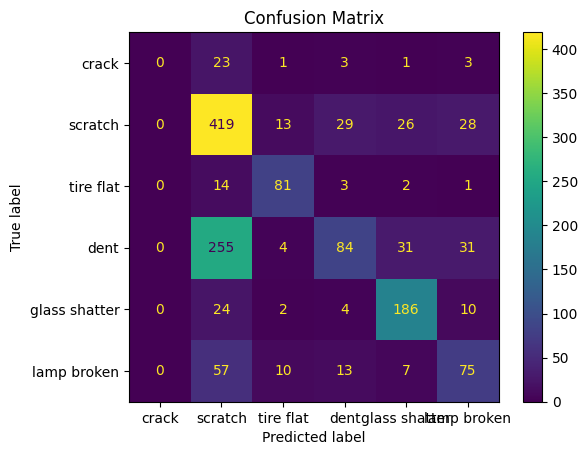

In [27]:
## Checking for overfitting

# Plot training loss against validation loss
#Plots the training loss as a line with label "Training Loss".
plt.plot(history.history['loss'], label='Training Loss')
#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Loss".
plt.ylabel('Loss = Cross Entropy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()


# Plot training and validation accuracy
#Plots the training accuracy as a line with label "Training Accuracy".
plt.plot(history.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Accuracy".
plt.ylabel('Accuracy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

# Predict the classes of the test set
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred, display_labels=class_names_list)
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Hyperparameter tuning with original batch size but increased kernal size (5 by 5)

# 2-dimensional Convolution layer (Conv2D) with 200 filters, a kernel size of 3x3, and the ReLU activation function
# Ensure that the input shape matches the shape of the input images (100, 100, 3) (height, width, # of channels)

model = Sequential()

# 1st layer and sets the input shape
model.add(Input(shape=(100, 100, 3)))

# Convolution layer for 200 filters, 
# kernel size (width x height), 
# and a function for non-linear activation (relu)
# Padding keeps output the same size as input
model.add(Conv2D(filters=100, kernel_size=(5,5), activation='relu', padding='same'))

# Pooling layer to "simplify" and "contrast" data passing through the network
model.add(MaxPooling2D(pool_size=(2,2)))

# Add second convulution layer, increasing the filter count as is the norm
model.add(Conv2D(filters=200, kernel_size=(5,5), activation='relu', padding='same'))

# Add a second max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

# Add a third convolutional layer
model.add(Conv2D(filters=400, kernel_size=(5,5), activation='relu', padding='same'))

# Add a third max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten our multidimensional outputs to a 1D array
model.add(Flatten())

# Add a Dense layer with fully connected neurons
model.add(Dense(200,  activation='relu'))

# Dropout rate of 50%
model.add(Dropout(0.5))

# 6 units for the 6 output classes
# Softmax activation function to output values as probabilities for the 6 classes
model.add(Dense(6,  activation='softmax'))


model.summary()

# Compile
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Train (with increased batch size)
history=model.fit(train_datagen.flow(x_train, keras.utils.to_categorical(y_train), batch_size=32),
                  epochs=20, validation_data=(x_test, keras.utils.to_categorical(y_test)))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 100, 100, 100)       │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 50, 50, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 50, 50, 200)         │         500,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 25, 25, 200)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 25, 25, 400)         │       2,000,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 400)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 200)                 │      11,520,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,206 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,029,606 (53.52 MB)

 Trainable params: 14,029,606 (53.52 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.2960 - loss: 1.6205 - val_accuracy: 0.3653 - val_loss: 1.5065
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 462s 3s/step - accuracy: 0.3450 - loss: 1.5080 - val_accuracy: 0.4250 - val_loss: 1.3529
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.3647 - loss: 1.4649 - val_accuracy: 0.3438 - val_loss: 1.4024
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 474s 3s/step - accuracy: 0.4251 - loss: 1.3588 - val_accuracy: 0.4722 - val_loss: 1.2493
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 499s 3s/step - accuracy: 0.4596 - loss: 1.2930 - val_accuracy: 0.4847 - val_loss: 1.1688
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 473s 3s/step - accuracy: 0.4804 - loss: 1.2376 - val_accuracy: 0.5139 - val_loss: 1.1169
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.4855 - loss: 1.1814 - val_accuracy: 0.5222 - val_loss: 1.0818
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 493s 3s/step - accuracy: 0.5073 - loss: 1.1704 - val_accu

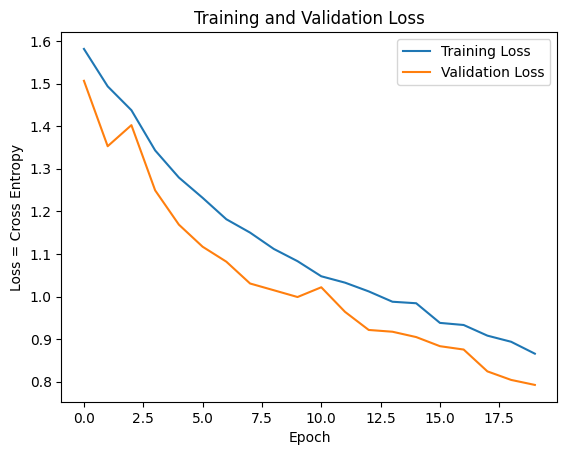

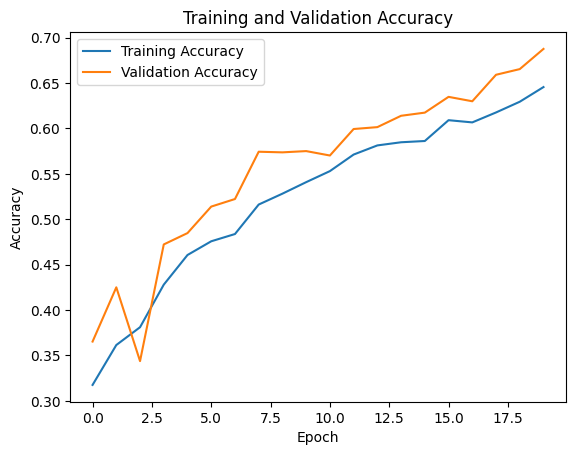

45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 668ms/step
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        31
           1       0.63      0.81      0.71       515
           2       0.86      0.89      0.87       101
           3       0.60      0.50      0.55       405
           4       0.89      0.84      0.86       226
           5       0.72      0.56      0.63       162

    accuracy                           0.69      1440
   macro avg       0.78      0.60      0.61      1440
weighted avg       0.70      0.69      0.68      1440



<Figure size 2000x3000 with 0 Axes>

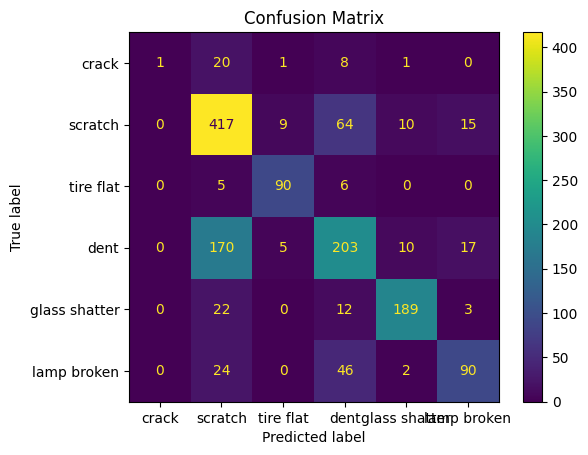

In [30]:
## Checking for overfitting

# Plot training loss against validation loss
#Plots the training loss as a line with label "Training Loss".
plt.plot(history.history['loss'], label='Training Loss')
#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Loss".
plt.ylabel('Loss = Cross Entropy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()


# Plot training and validation accuracy
#Plots the training accuracy as a line with label "Training Accuracy".
plt.plot(history.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Accuracy".
plt.ylabel('Accuracy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

# Predict the classes of the test set
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred, display_labels=class_names_list)
plt.title('Confusion Matrix')
plt.show()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 100, 100, 100)       │          14,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 50, 50, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 50, 50, 200)         │         980,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 25, 25, 200)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 25, 25, 400)         │       3,920,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 400)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 200)                 │      11,520,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │           1,206 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,436,806 (62.70 MB)

 Trainable params: 16,436,806 (62.70 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 902s 5s/step - accuracy: 0.2961 - loss: 1.6285 - val_accuracy: 0.3715 - val_loss: 1.4996
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 952s 5s/step - accuracy: 0.3252 - loss: 1.5551 - val_accuracy: 0.3319 - val_loss: 1.4830
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 962s 5s/step - accuracy: 0.3319 - loss: 1.5195 - val_accuracy: 0.4035 - val_loss: 1.4212
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 950s 5s/step - accuracy: 0.3592 - loss: 1.4944 - val_accuracy: 0.4097 - val_loss: 1.3950
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 952s 5s/step - accuracy: 0.3770 - loss: 1.4321 - val_accuracy: 0.3854 - val_loss: 1.3840
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 917s 5s/step - accuracy: 0.4052 - loss: 1.4045 - val_accuracy: 0.4868 - val_loss: 1.2543
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 959s 5s/step - accuracy: 0.4425 - loss: 1.3236 - val_accuracy: 0.4910 - val_loss: 1.1900
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 943s 5s/step - accuracy: 0.4681 - loss: 1.2496 - val_accu

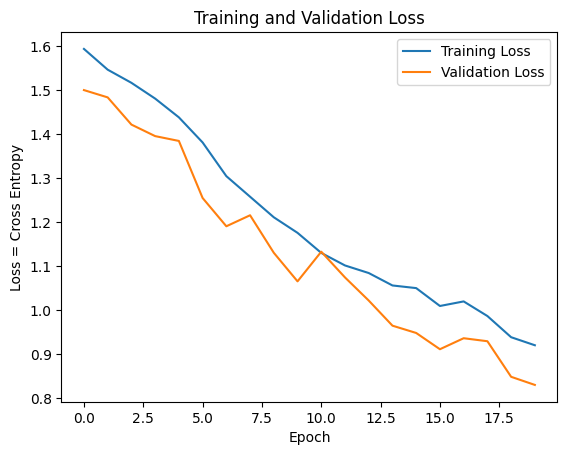

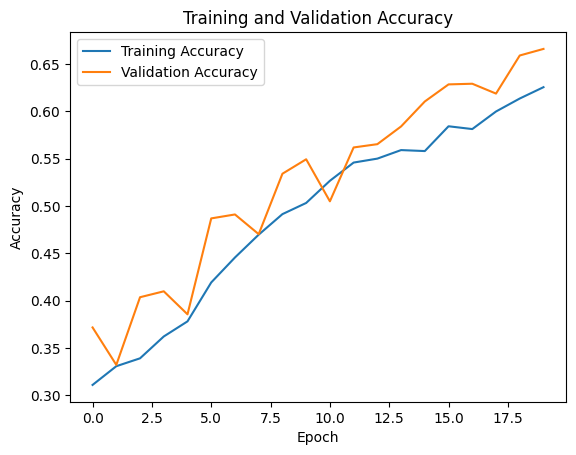

45/45 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        31
           1       0.64      0.75      0.69       515
           2       0.89      0.80      0.84       101
           3       0.57      0.54      0.55       405
           4       0.79      0.85      0.82       226
           5       0.68      0.50      0.57       162

    accuracy                           0.67      1440
   macro avg       0.76      0.58      0.59      1440
weighted avg       0.67      0.67      0.66      1440



<Figure size 2000x3000 with 0 Axes>

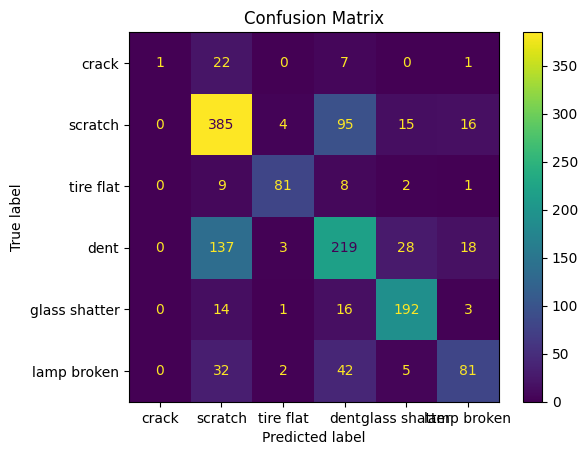

In [31]:
# Hyperparameter tuning with original batch size but increased kernal size (7 by 7)

# 2-dimensional Convolution layer (Conv2D) with 200 filters, a kernel size of 3x3, and the ReLU activation function
# Ensure that the input shape matches the shape of the input images (100, 100, 3) (height, width, # of channels)

model = Sequential()

# 1st layer and sets the input shape
model.add(Input(shape=(100, 100, 3)))

# Convolution layer for 200 filters, 
# kernel size (width x height), 
# and a function for non-linear activation (relu)
# Padding keeps output the same size as input
model.add(Conv2D(filters=100, kernel_size=(7,7), activation='relu', padding='same'))

# Pooling layer to "simplify" and "contrast" data passing through the network
model.add(MaxPooling2D(pool_size=(2,2)))

# Add second convulution layer, increasing the filter count as is the norm
model.add(Conv2D(filters=200, kernel_size=(7,7), activation='relu', padding='same'))

# Add a second max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

# Add a third convolutional layer
model.add(Conv2D(filters=400, kernel_size=(7,7), activation='relu', padding='same'))

# Add a third max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten our multidimensional outputs to a 1D array
model.add(Flatten())

# Add a Dense layer with fully connected neurons
model.add(Dense(200,  activation='relu'))

# Dropout rate of 50%
model.add(Dropout(0.5))

# 6 units for the 6 output classes
# Softmax activation function to output values as probabilities for the 6 classes
model.add(Dense(6,  activation='softmax'))


model.summary()

# Compile
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Train (with increased batch size)
history=model.fit(train_datagen.flow(x_train, keras.utils.to_categorical(y_train), batch_size=32),
                  epochs=20, validation_data=(x_test, keras.utils.to_categorical(y_test)))



# Results?

# Checking for overfitting

# Plot training loss against validation loss
#Plots the training loss as a line with label "Training Loss".
plt.plot(history.history['loss'], label='Training Loss')
#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Loss".
plt.ylabel('Loss = Cross Entropy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()


# Plot training and validation accuracy
#Plots the training accuracy as a line with label "Training Accuracy".
plt.plot(history.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Accuracy".
plt.ylabel('Accuracy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

# Predict the classes of the test set
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred, display_labels=class_names_list)
plt.title('Confusion Matrix')
plt.show()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 100, 100, 100)       │           2,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 50, 50, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 50, 50, 200)         │         180,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 25, 25, 200)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 25, 25, 400)         │         720,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 12, 12, 400)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 200)                 │      11,520,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │           1,206 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,424,806 (47.40 MB)

 Trainable params: 12,424,806 (47.40 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.3045 - loss: 1.5799 - val_accuracy: 0.4208 - val_loss: 1.3897
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.3977 - loss: 1.3991 - val_accuracy: 0.4694 - val_loss: 1.2909
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.4493 - loss: 1.2914 - val_accuracy: 0.5056 - val_loss: 1.1539
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.4767 - loss: 1.2126 - val_accuracy: 0.4729 - val_loss: 1.2213
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.4939 - loss: 1.1850 - val_accuracy: 0.5271 - val_loss: 1.1126
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.5256 - loss: 1.1043 - val_accuracy: 0.5389 - val_loss: 1.0991
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.5453 - loss: 1.1015 - val_accuracy: 0.5569 - val_loss: 1.0688
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.5537 - loss: 1.0306 - val_accu

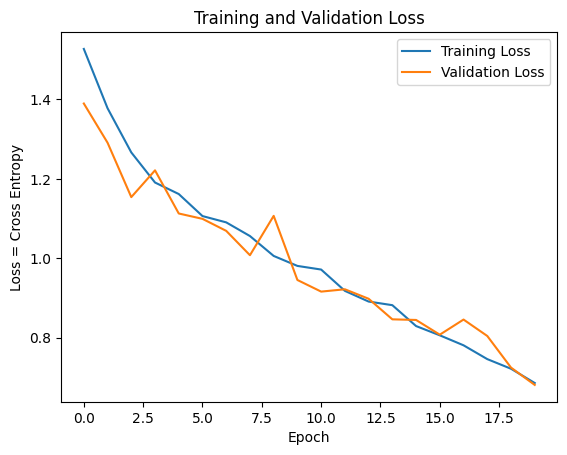

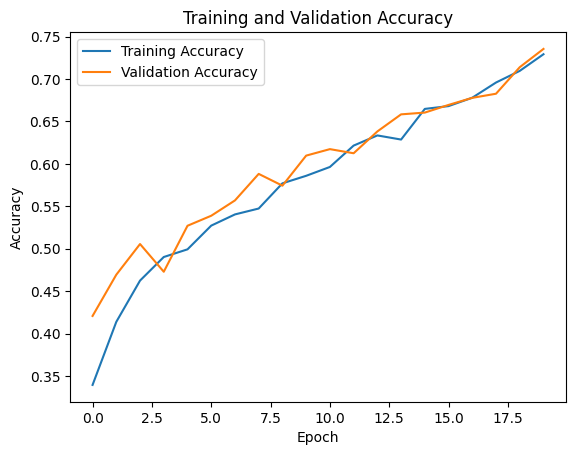

45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step
              precision    recall  f1-score   support

           0       0.47      0.29      0.36        31
           1       0.72      0.72      0.72       515
           2       0.89      0.89      0.89       101
           3       0.67      0.67      0.67       405
           4       0.92      0.90      0.91       226
           5       0.63      0.72      0.67       162

    accuracy                           0.74      1440
   macro avg       0.72      0.70      0.70      1440
weighted avg       0.74      0.74      0.73      1440



<Figure size 2000x3000 with 0 Axes>

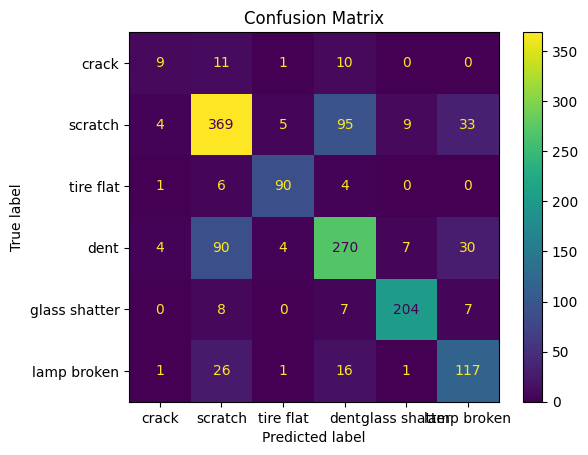

In [39]:
# Check how original model performs without regularizing (10% dropout and no random image transformations)

# 2-dimensional Convolution layer (Conv2D) with 200 filters, a kernel size of 3x3, and the ReLU activation function
# Ensure that the input shape matches the shape of the input images (100, 100, 3) (height, width, # of channels)

model = Sequential()

# 1st layer and sets the input shape
model.add(Input(shape=(100, 100, 3)))

# Convolution layer for 200 filters, 
# kernel size (width x height), 
# and a function for non-linear activation (relu)
# Padding keeps output the same size as input
model.add(Conv2D(filters=100, kernel_size=(3,3), activation='relu', padding='same'))

# Pooling layer to "simplify" and "contrast" data passing through the network
model.add(MaxPooling2D(pool_size=(2,2)))

# Add second convulution layer, increasing the filter count as is the norm
model.add(Conv2D(filters=200, kernel_size=(3,3), activation='relu', padding='same'))

# Add a second max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

# Add a third convolutional layer
model.add(Conv2D(filters=400, kernel_size=(3,3), activation='relu', padding='same'))

# Add a third max pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten our multidimensional outputs to a 1D array
model.add(Flatten())

# Add a Dense layer with fully connected neurons
model.add(Dense(200,  activation='relu'))

# Dropout rate of 50%
model.add(Dropout(0.1))

# 6 units for the 6 output classes
# Softmax activation function to output values as probabilities for the 6 classes
model.add(Dense(6,  activation='softmax'))


model.summary()

# Compile
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Train (with increased batch size)
history=model.fit(train_datagen.flow(x_train, keras.utils.to_categorical(y_train), batch_size=32),
                  epochs=20, validation_data=(x_test, keras.utils.to_categorical(y_test)))



# Results?

# Checking for overfitting

# Plot training loss against validation loss
#Plots the training loss as a line with label "Training Loss".
plt.plot(history.history['loss'], label='Training Loss')
#Plots the validation loss as a line with label "Validation Loss".
plt.plot(history.history['val_loss'], label='Validation Loss')
#Sets the title of the plot to "Training and Validation Loss".
plt.title('Training and Validation Loss')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Loss".
plt.ylabel('Loss = Cross Entropy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()


# Plot training and validation accuracy
#Plots the training accuracy as a line with label "Training Accuracy".
plt.plot(history.history['accuracy'], label='Training Accuracy')
#Plots the validation accuracy as a line with label "Validation Accuracy".
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#Sets the title of the plot to "Training and Validation Accuracy".
plt.title('Training and Validation Accuracy')
#Sets the label of the x-axis to "Epochs".
plt.xlabel('Epoch')
#Sets the label of the y-axis to "Accuracy".
plt.ylabel('Accuracy')
#Shows the legend of the plot with the labels of the two lines.
plt.legend()
#Shows the plot on the screen.
plt.show()

# Predict the classes of the test set
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred, display_labels=class_names_list)
plt.title('Confusion Matrix')
plt.show()